# Feedback Clustering Experiment

Interactive exploration of SentenceTransformer models and clustering algorithms
for grouping EU "Have Your Say" feedback items by semantic similarity.

Workflow: load initiative → build text corpus → embed → reduce dimensions → cluster → analyze.

In [89]:
import json
import os
import time
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import hdbscan
from umap import UMAP

import warnings 

warnings.filterwarnings("ignore", message="invalid value encountered in matmul")   

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ── Config ──────────────────────────────────────────────────────────────────
INITIATIVE_ID = "14240"  # initiative to load
MODEL_NAME = "paraphrase-multilingual-MiniLM-L12-v2"

# Set True to use pre-computed summaries instead of raw extracted text.
# Loads from SUMMARIES_DIR and uses combined_feedback_summary / attachment summary fields.
USE_SUMMARIES = True
SUMMARIES_DIR = "unit_summaries"

# Output directory for clustering result JSONs
OUTPUT_DIR = "clustering_output"

# HDBSCAN
HDBSCAN_MIN_CLUSTER_SIZE = 5
HDBSCAN_MIN_SAMPLES = 3

# KMeans
KMEANS_N_CLUSTERS = 8

# Agglomerative (fixed k)
AGGLOM_N_CLUSTERS = 8
AGGLOM_LINKAGE = "ward"  # ward, complete, average, single

# Agglomerative (auto k via distance threshold — used in compare models)
AGGLOM_DISTANCE_THRESHOLD = 1.5

# UMAP
UMAP_N_NEIGHBORS = 15
UMAP_MIN_DIST = 0.1


def save_clustering(initiative, df, cluster_col, embeddings, model_name, algorithm, params):
    """Save a clone of the initiative JSON with clustering results at the top level."""
    result = copy.deepcopy(initiative)

    assignments = {str(row["feedback_id"]): int(row[cluster_col]) for _, row in df.iterrows()}

    labels = df[cluster_col].values
    unique_labels = set(labels) - {-1}
    n_clusters = len(unique_labels)
    noise_count = int((labels == -1).sum())

    sil = None
    if n_clusters >= 2:
        non_noise = labels != -1
        if non_noise.all():
            sil = float(silhouette_score(embeddings, labels))
        else:
            sil = float(silhouette_score(embeddings[non_noise], labels[non_noise]))

    result["cluster_model"] = model_name
    result["cluster_algorithm"] = algorithm
    result["cluster_params"] = params
    result["cluster_n_clusters"] = n_clusters
    result["cluster_noise_count"] = noise_count
    result["cluster_silhouette"] = sil
    result["cluster_assignments"] = assignments

    model_safe = model_name.replace("/", "_")
    param_str = "_".join(f"{k}={v}" for k, v in sorted(params.items()))
    filename = f"{INITIATIVE_ID}_{algorithm}_{model_safe}_{param_str}.json"

    os.makedirs(OUTPUT_DIR, exist_ok=True)
    out_path = os.path.join(OUTPUT_DIR, filename)
    with open(out_path, "w") as f:
        json.dump(result, f, indent=2)
    print(f"  -> Saved: {out_path}")

Using device: cpu


In [90]:
# ── Load initiative data ───────────────────────────────────────────────────
if USE_SUMMARIES:
    src_path = os.path.join(SUMMARIES_DIR, f"{INITIATIVE_ID}.json")
else:
    src_path = os.path.join("initiative_details", f"{INITIATIVE_ID}.json")

print(f"Loading: {src_path}  (USE_SUMMARIES={USE_SUMMARIES})")
with open(src_path) as f:
    initiative = json.load(f)

print(f"Initiative: {initiative.get('short_title', initiative.get('id'))}")
print(f"ID: {initiative['id']}")

rows = []

if USE_SUMMARIES:
    # unit_summaries / summaries_output_v9 have middle_feedback at top level
    # with combined_feedback_summary and attachment summary fields.
    for fb in initiative.get("middle_feedback", []):
        raw_fb = fb.get("feedback_text", "") or ""
        raw_att_parts = []
        sum_att_parts = []
        for att in fb.get("attachments", []):
            raw_att_parts.append(att.get("extracted_text", "") or "")
            sum_att_parts.append(att.get("summary", "") or "")
        raw_att = "\n\n".join(filter(None, raw_att_parts))
        sum_att = "\n\n".join(filter(None, sum_att_parts))

        raw_combined = "\n\n".join(filter(None, [raw_fb, raw_att]))

        # combined_feedback_summary already folds in attachment summaries
        cfs = fb.get("combined_feedback_summary", "") or ""
        if cfs:
            combined = cfs
        else:
            # no summary available — use feedback_text + attachment summaries (or raw fallback)
            combined = "\n\n".join(filter(None, [raw_fb, sum_att or raw_att]))

        rows.append({
            "feedback_id": fb["id"],
            "publication_id": None,
            "user_type": fb.get("user_type", ""),
            "country": fb.get("country", ""),
            "organization": fb.get("organization", ""),
            "language": fb.get("language", ""),
            "date": fb.get("date", ""),
            "feedback_text": raw_fb,
            "attachment_text": sum_att or raw_att,
            "combined_text": combined,
            "raw_combined_text": raw_combined,
        })
else:
    for pub in initiative.get("publications", []):
        pub_id = pub["publication_id"]
        for fb in pub.get("feedback", []):
            feedback_text = fb.get("feedback_text", "") or ""
            att_parts = []
            for att in fb.get("attachments", []):
                att_text = att.get("extracted_text", "") or att.get("summary", "") or ""
                if att_text:
                    att_parts.append(att_text)
            attachment_text = "\n\n".join(att_parts)
            combined = "\n\n".join(filter(None, [feedback_text, attachment_text]))
            rows.append({
                "feedback_id": fb["id"],
                "publication_id": pub_id,
                "user_type": fb.get("user_type", ""),
                "country": fb.get("country", ""),
                "organization": fb.get("organization", ""),
                "language": fb.get("language", ""),
                "date": fb.get("date", ""),
                "feedback_text": feedback_text,
                "attachment_text": attachment_text,
                "combined_text": combined,
                "raw_combined_text": combined,
            })

df = pd.DataFrame(rows)
print(f"Total feedback items: {len(df)}")
df.head()

Loading: unit_summaries/14240.json  (USE_SUMMARIES=True)
Initiative: Application of the ‘do no significant harm’ principle to the Social Climate Fund and its possible future extension
ID: 14240
Total feedback items: 71


,feedback_id,publication_id,user_type,country,organization,language,date,feedback_text,attachment_text,combined_text,raw_combined_text
0,3467313,None,PUBLIC_AUTHORITY,POL,M,PL,2024/05/28 23:59:47,Welcomes the opportunity to express an opinion...,,Welcomes the opportunity to express an opinion...,Welcomes the opportunity to express an opinion...
1,3467311,None,OTHER,FRA,Bpifrance,EN,2024/05/28 23:10:29,Please see the attached document,**1. Scope and purpose** – On 24 May 2022 Bpif...,Please see the attached document\n\n**1. Scope...,Please see the attached document\n\n \n \n \n ...
2,3467293,None,NGO,ESP,ONCE Social Group,EN,2024/05/28 21:34:13,The European Union's Social Climate Fund (SCF)...,**Paragraph 1 – Purpose of the submission** \...,The European Union's Social Climate Fund (SCF)...,The European Union's Social Climate Fund (SCF)...
3,3467281,None,BUSINESS_ASSOCIATION,BEL,EuRIC,EN,2024/05/28 20:13:35,EuRIC welcomes the development of do not signi...,**1.** EuRIC welcomes the EU’s move to develop...,EuRIC welcomes the development of do not signi...,EuRIC welcomes the development of do not signi...
4,3467272,None,TRADE_UNION,BEL,ETUC,EN,2024/05/28 19:27:03,The ETUC welcomes the Social Climate Fund (SCF...,,The ETUC welcomes the Social Climate Fund (SCF...,The ETUC welcomes the Social Climate Fund (SCF...


Feedback with text:        71 / 71
Feedback with attachments:  35 / 71
Empty (no text at all):     0

── Summary text (combined_text) ──────────────────
count       71.000000
mean      4677.450704
std       3333.938331
min        169.000000
25%       1798.000000
50%       3983.000000
75%       7553.500000
max      11523.000000

── Original raw text ─────────────────────────────
count        71.000000
mean       8278.281690
std       14645.056376
min         169.000000
25%        1798.000000
50%        3983.000000
75%        9186.000000
max      105722.000000

Total text reduction: 43.5%


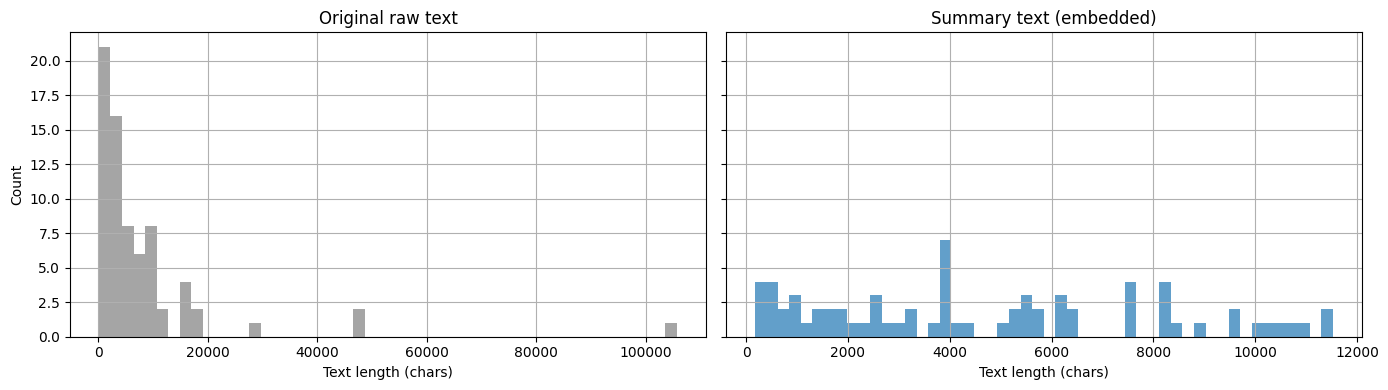


Keeping 71 feedback items with text.


In [91]:
# ── Text stats ─────────────────────────────────────────────────────────────
df["text_len"] = df["combined_text"].str.len()
df["raw_text_len"] = df["raw_combined_text"].str.len()
has_text = df["text_len"] > 0
has_attachment = df["attachment_text"].str.len() > 0

print(f"Feedback with text:        {has_text.sum()} / {len(df)}")
print(f"Feedback with attachments:  {has_attachment.sum()} / {len(df)}")
print(f"Empty (no text at all):     {(~has_text).sum()}")

if USE_SUMMARIES:
    print(f"\n{'── Summary text (combined_text) ──':─<50}")
    print(df.loc[has_text, "text_len"].describe().to_string())
    print(f"\n{'── Original raw text ──':─<50}")
    print(df.loc[has_text, "raw_text_len"].describe().to_string())
    reduction = 1 - df.loc[has_text, "text_len"].sum() / df.loc[has_text, "raw_text_len"].sum()
    print(f"\nTotal text reduction: {reduction:.1%}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
    df.loc[has_text, "raw_text_len"].hist(bins=50, ax=ax1, color="tab:gray", alpha=0.7)
    ax1.set_xlabel("Text length (chars)")
    ax1.set_ylabel("Count")
    ax1.set_title("Original raw text")
    df.loc[has_text, "text_len"].hist(bins=50, ax=ax2, color="tab:blue", alpha=0.7)
    ax2.set_xlabel("Text length (chars)")
    ax2.set_title("Summary text (embedded)")
    plt.tight_layout()
    plt.show()
else:
    print()
    print(df.loc[has_text, "text_len"].describe().to_string())
    fig, ax = plt.subplots(figsize=(10, 4))
    df.loc[has_text, "text_len"].hist(bins=50, ax=ax)
    ax.set_xlabel("Combined text length (chars)")
    ax.set_ylabel("Count")
    ax.set_title("Text length distribution")
    plt.tight_layout()
    plt.show()

# Filter to only feedback with text
df = df[has_text].reset_index(drop=True)
print(f"\nKeeping {len(df)} feedback items with text.")

In [92]:
# ── Encode with SentenceTransformer ────────────────────────────────────────
print(f"Loading model: {MODEL_NAME} (device={DEVICE})")
model = SentenceTransformer(MODEL_NAME, device=DEVICE)

t0 = time.time()
embeddings = model.encode(df["combined_text"].tolist(), show_progress_bar=True)
embeddings = normalize(embeddings)
elapsed = time.time() - t0

print(f"Embedding shape: {embeddings.shape}")
print(f"Time: {elapsed:.1f}s ({len(df) / elapsed:.0f} items/s)")
print(f"Embeddings L2-normalized (sample norm: {np.linalg.norm(embeddings[0]):.4f})")

Loading model: paraphrase-multilingual-MiniLM-L12-v2 (device=cpu)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Embedding shape: (71, 384)
Time: 0.3s (215 items/s)
Embeddings L2-normalized (sample norm: 1.0000)


/Users/mahae/venvs/test/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/gx/m4r_gc751jq23rrrjzcrs5xr0000gn/T/ipykernel_7433/2297222461.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(categories))


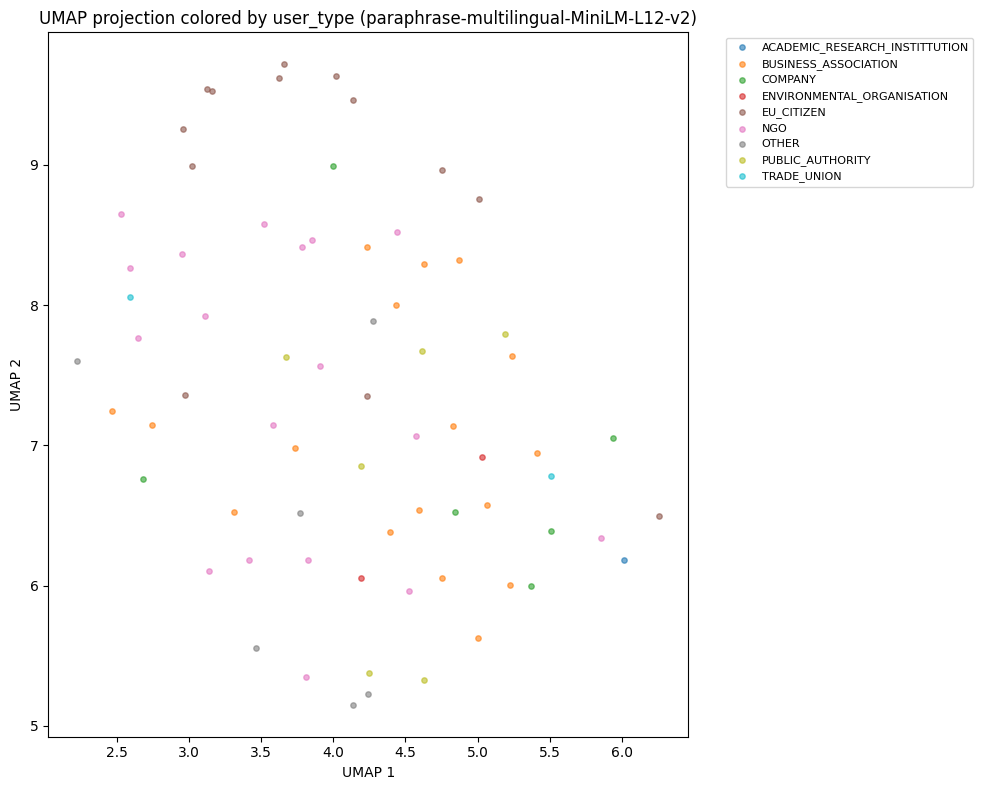

In [93]:
# ── UMAP dimensionality reduction ──────────────────────────────────────────
reducer = UMAP(n_neighbors=UMAP_N_NEIGHBORS, min_dist=UMAP_MIN_DIST, random_state=42)
umap_2d = reducer.fit_transform(embeddings)
df["umap_x"] = umap_2d[:, 0]
df["umap_y"] = umap_2d[:, 1]

# Color by user_type
user_types = df["user_type"].fillna("unknown").replace("", "unknown")
categories = sorted(user_types.unique())
cmap = plt.cm.get_cmap("tab10", len(categories))
color_map = {cat: cmap(i) for i, cat in enumerate(categories)}

fig, ax = plt.subplots(figsize=(10, 8))
for cat in categories:
    mask = user_types == cat
    ax.scatter(df.loc[mask, "umap_x"], df.loc[mask, "umap_y"],
               label=cat, alpha=0.6, s=15, color=color_map[cat])
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
ax.set_title(f"UMAP projection colored by user_type ({MODEL_NAME})")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
plt.tight_layout()
plt.show()

HDBSCAN: 3 clusters, 12 noise points (16.9%)

hdbscan_cluster
-1    12
 0    41
 1     8
 2    10


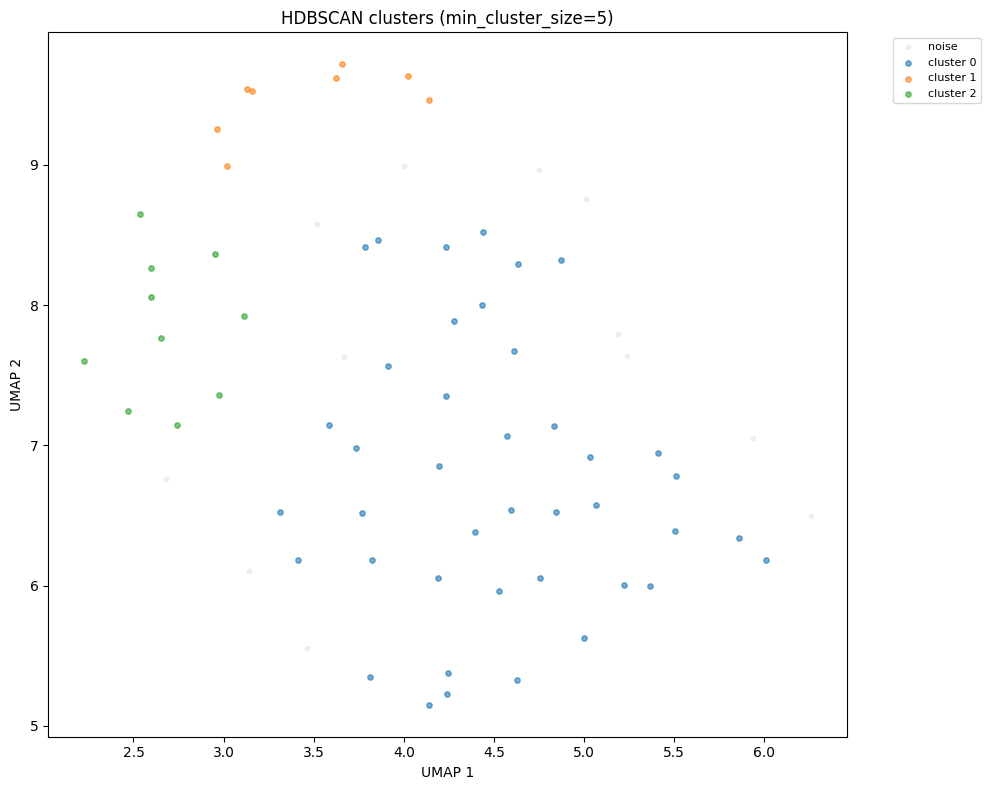

  -> Saved: clustering_output/14240_hdbscan_paraphrase-multilingual-MiniLM-L12-v2_min_cluster_size=5_min_samples=3.json


/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


In [94]:
# ── HDBSCAN clustering ─────────────────────────────────────────────────────
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
)
df["hdbscan_cluster"] = clusterer.fit_predict(umap_2d)

n_clusters = df["hdbscan_cluster"].nunique() - (1 if -1 in df["hdbscan_cluster"].values else 0)
n_noise = (df["hdbscan_cluster"] == -1).sum()
print(f"HDBSCAN: {n_clusters} clusters, {n_noise} noise points ({n_noise/len(df)*100:.1f}%)")
print()
print(df["hdbscan_cluster"].value_counts().sort_index().to_string())

fig, ax = plt.subplots(figsize=(10, 8))
noise = df["hdbscan_cluster"] == -1
ax.scatter(df.loc[noise, "umap_x"], df.loc[noise, "umap_y"],
           c="lightgray", alpha=0.3, s=10, label="noise")
for cl in sorted(df.loc[~noise, "hdbscan_cluster"].unique()):
    mask = df["hdbscan_cluster"] == cl
    ax.scatter(df.loc[mask, "umap_x"], df.loc[mask, "umap_y"],
               alpha=0.6, s=15, label=f"cluster {cl}")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
ax.set_title(f"HDBSCAN clusters (min_cluster_size={HDBSCAN_MIN_CLUSTER_SIZE})")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
plt.tight_layout()
plt.show()

save_clustering(initiative, df, "hdbscan_cluster", embeddings, MODEL_NAME, "hdbscan", {
    "min_cluster_size": HDBSCAN_MIN_CLUSTER_SIZE, "min_samples": HDBSCAN_MIN_SAMPLES,
})

KMeans (k=8): silhouette score = 0.072

kmeans_cluster
0    29
1    23
2     5
3     2
4     5
5     3
6     3
7     1


/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


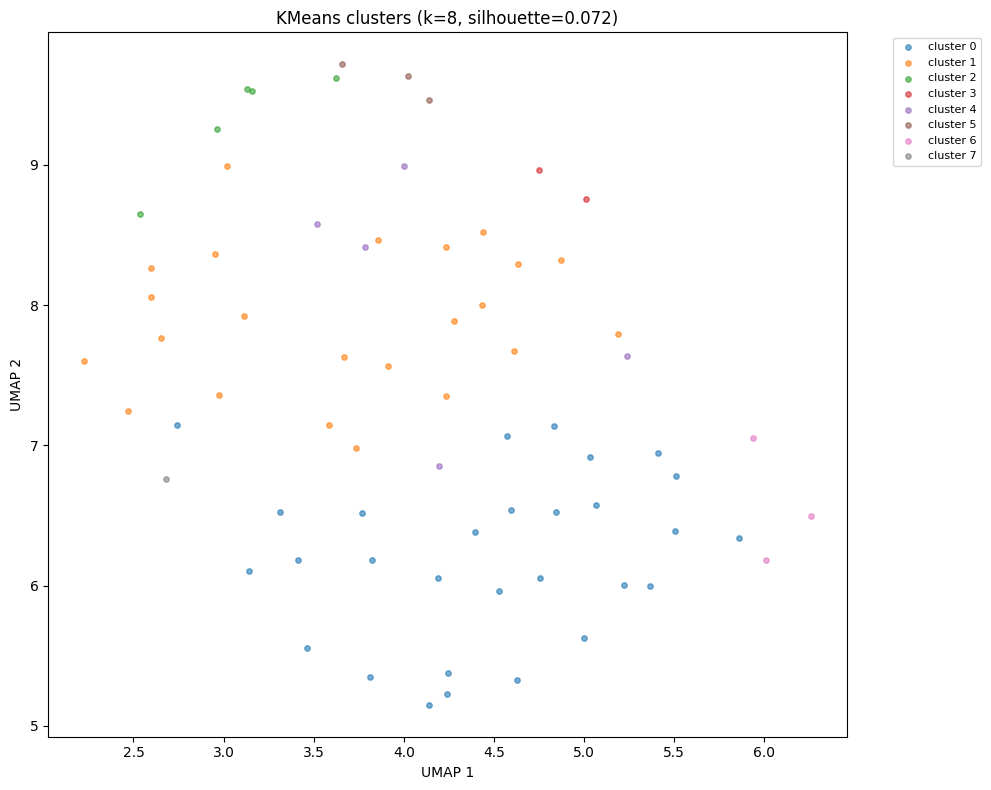

  -> Saved: clustering_output/14240_kmeans_paraphrase-multilingual-MiniLM-L12-v2_n_clusters=8.json


/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


In [95]:
# ── KMeans clustering ──────────────────────────────────────────────────────
kmeans = KMeans(n_clusters=KMEANS_N_CLUSTERS, random_state=42, n_init=10)
df["kmeans_cluster"] = kmeans.fit_predict(embeddings)

sil = silhouette_score(embeddings, df["kmeans_cluster"])
print(f"KMeans (k={KMEANS_N_CLUSTERS}): silhouette score = {sil:.3f}")
print()
print(df["kmeans_cluster"].value_counts().sort_index().to_string())

fig, ax = plt.subplots(figsize=(10, 8))
for cl in sorted(df["kmeans_cluster"].unique()):
    mask = df["kmeans_cluster"] == cl
    ax.scatter(df.loc[mask, "umap_x"], df.loc[mask, "umap_y"],
               alpha=0.6, s=15, label=f"cluster {cl}")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
ax.set_title(f"KMeans clusters (k={KMEANS_N_CLUSTERS}, silhouette={sil:.3f})")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
plt.tight_layout()
plt.show()

save_clustering(initiative, df, "kmeans_cluster", embeddings, MODEL_NAME, "kmeans", {
    "n_clusters": KMEANS_N_CLUSTERS,
})

Agglomerative (n=8, linkage=ward): silhouette = 0.062

agglom_cluster
0     4
1     8
2    10
3     5
4     2
5    18
6    21
7     3


/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


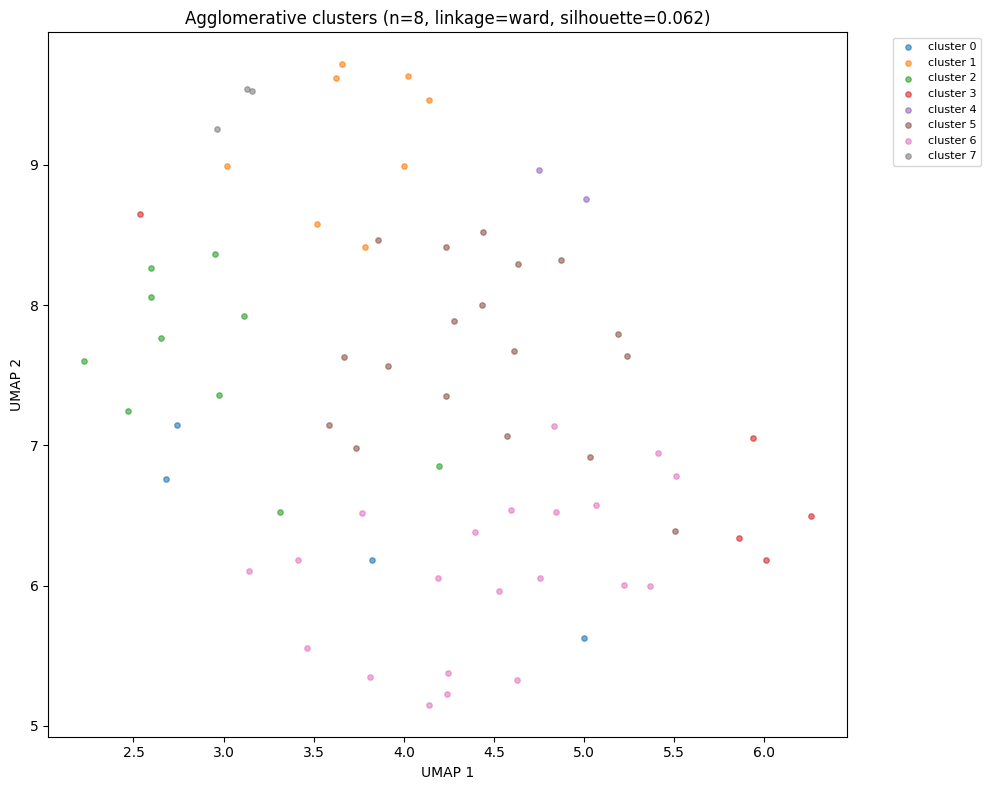

  -> Saved: clustering_output/14240_agglomerative_paraphrase-multilingual-MiniLM-L12-v2_linkage=ward_n_clusters=8.json


/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


In [96]:
# ── Agglomerative clustering ───────────────────────────────────────────────
# Uses ward linkage on full embeddings by default. Switch to "average" or
# "complete" linkage to use cosine-based precomputed distances instead.
if AGGLOM_LINKAGE == "ward":
    agglom = AgglomerativeClustering(n_clusters=AGGLOM_N_CLUSTERS, linkage="ward")
    df["agglom_cluster"] = agglom.fit_predict(embeddings)
else:
    from sklearn.metrics import pairwise_distances
    dist = pairwise_distances(embeddings, metric="cosine")
    agglom = AgglomerativeClustering(
        n_clusters=AGGLOM_N_CLUSTERS, linkage=AGGLOM_LINKAGE, metric="precomputed"
    )
    df["agglom_cluster"] = agglom.fit_predict(dist)

sil_agglom = silhouette_score(embeddings, df["agglom_cluster"])
print(f"Agglomerative (n={AGGLOM_N_CLUSTERS}, linkage={AGGLOM_LINKAGE}): silhouette = {sil_agglom:.3f}")
print()
print(df["agglom_cluster"].value_counts().sort_index().to_string())

fig, ax = plt.subplots(figsize=(10, 8))
for cl in sorted(df["agglom_cluster"].unique()):
    mask = df["agglom_cluster"] == cl
    ax.scatter(df.loc[mask, "umap_x"], df.loc[mask, "umap_y"],
               alpha=0.6, s=15, label=f"cluster {cl}")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
ax.set_title(f"Agglomerative clusters (n={AGGLOM_N_CLUSTERS}, linkage={AGGLOM_LINKAGE}, silhouette={sil_agglom:.3f})")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
plt.tight_layout()
plt.show()

save_clustering(initiative, df, "agglom_cluster", embeddings, MODEL_NAME, "agglomerative", {
    "linkage": AGGLOM_LINKAGE, "n_clusters": AGGLOM_N_CLUSTERS,
})

Agglomerative (distance_threshold=0.98, linkage=average): 16 clusters, silhouette = 0.093

agglom_dt_cluster
0     46
1      2
2      7
3      2
4      1
5      2
6      1
7      1
8      1
9      1
10     1
11     1
12     2
13     1
14     1
15     1


/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


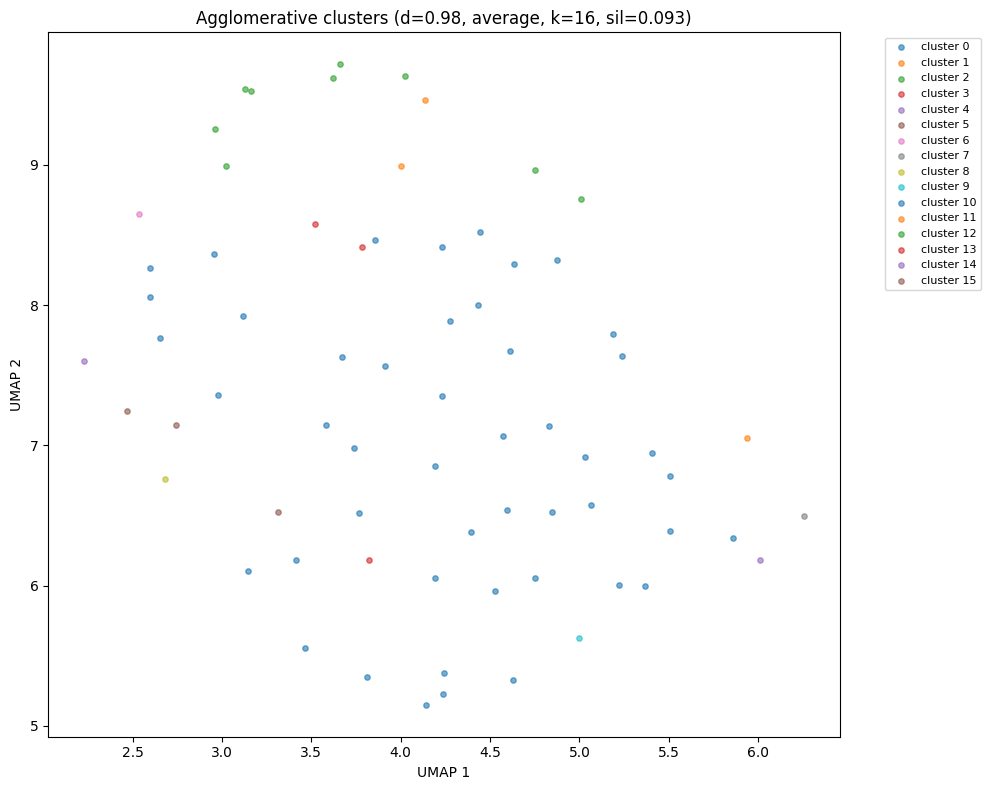

  -> Saved: clustering_output/14240_agglomerative_paraphrase-multilingual-MiniLM-L12-v2_distance_threshold=0.98_linkage=average.json


/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


In [97]:



ag_dt = AgglomerativeClustering(
    n_clusters=None, distance_threshold=AGGLOM_DT_ANALYSIS, linkage=AGGLOM_DT_LINKAGE
)
df["agglom_dt_cluster"] = ag_dt.fit_predict(embeddings)

ag_dt_n = df["agglom_dt_cluster"].nunique()
ag_dt_sil = silhouette_score(embeddings, df["agglom_dt_cluster"]) if ag_dt_n >= 2 else float("nan")
print(f"Agglomerative (distance_threshold={AGGLOM_DT_ANALYSIS}, linkage={AGGLOM_DT_LINKAGE}): "
      f"{ag_dt_n} clusters, silhouette = {ag_dt_sil:.3f}")
print()
print(df["agglom_dt_cluster"].value_counts().sort_index().to_string())

fig, ax = plt.subplots(figsize=(10, 8))
for cl in sorted(df["agglom_dt_cluster"].unique()):
    mask = df["agglom_dt_cluster"] == cl
    ax.scatter(df.loc[mask, "umap_x"], df.loc[mask, "umap_y"],
               alpha=0.6, s=15, label=f"cluster {cl}")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
ax.set_title(f"Agglomerative clusters (d={AGGLOM_DT_ANALYSIS}, {AGGLOM_DT_LINKAGE}, "
             f"k={ag_dt_n}, sil={ag_dt_sil:.3f})")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
plt.tight_layout()
plt.show()

save_clustering(initiative, df, "agglom_dt_cluster", embeddings, MODEL_NAME, "agglomerative", {
    "distance_threshold": AGGLOM_DT_ANALYSIS, "linkage": AGGLOM_DT_LINKAGE,
})

In [98]:
# ── Cluster analysis ───────────────────────────────────────────────────────
def analyze_clusters(df, cluster_col):
    """Print per-cluster breakdown: count, top user types, top countries, sample texts."""
    for cl in sorted(df[cluster_col].unique()):
        sub = df[df[cluster_col] == cl]
        label = "NOISE" if cl == -1 else f"Cluster {cl}"
        print(f"\n{'='*60}")
        print(f"{label}  (n={len(sub)})")
        print(f"{'='*60}")

        top_types = sub["user_type"].value_counts().head(5)
        if len(top_types):
            print(f"  User types: {dict(top_types)}")

        top_countries = sub["country"].replace("", "(empty)").value_counts().head(5)
        if len(top_countries):
            print(f"  Countries:  {dict(top_countries)}")

        print(f"  Sample texts:")
        for _, row in sub.head(3).iterrows():
            snippet = row["combined_text"][:400].replace("\n", " ")
            print(f"    - [{row['feedback_id']}] {snippet}...")

print("=== HDBSCAN clusters ===")
analyze_clusters(df, "hdbscan_cluster")

print("\n\n=== KMeans clusters ===")
analyze_clusters(df, "kmeans_cluster")

print("\n\n=== Agglomerative clusters ===")
analyze_clusters(df, "agglom_cluster")

print(f"\n\n=== Agglomerative clusters (d={AGGLOM_DT_ANALYSIS}, {AGGLOM_DT_LINKAGE}) ===")
analyze_clusters(df, "agglom_dt_cluster")

=== HDBSCAN clusters ===

NOISE  (n=12)
  User types: {'COMPANY': np.int64(3), 'EU_CITIZEN': np.int64(3), 'PUBLIC_AUTHORITY': np.int64(2), 'NGO': np.int64(2), 'OTHER': np.int64(1)}
  Countries:  {'DEU': np.int64(3), 'BEL': np.int64(2), 'ITA': np.int64(2), 'POL': np.int64(1), 'FRA': np.int64(1)}
  Sample texts:
    - [3467313] Welcomes the opportunity to express an opinion on the application of the Do No Significant Harm (DNSH) principle to the Social Climate Fund (SCF) and to share its reflections on its future enlargement under the next Multiannual Financial Framework; The creation of the SFC is an important response to the social impact of the new trading system for vulnerable groups in the EU. 1. It is appropriate t...
    - [3467264] Please find the position of EDF attached.  **1. EDF’s low‑carbon performance and corporate purpose**   In 2023 the EDF Group generated 93 % of its electricity from decarbonised sources, positioning it as the world’s leading low‑carbon electricity produ

Encoding with google/embeddinggemma-300m (device=cpu)...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/mahae/venvs/test/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: Runtime

Encoding with all-mpnet-base-v2 (device=cpu)...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/mahae/venvs/test/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: Runtime

Encoding with paraphrase-multilingual-MiniLM-L12-v2 (device=cpu)...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/mahae/venvs/test/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: Runtime

Encoding with all-MiniLM-L6-v2 (device=cpu)...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/mahae/venvs/test/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: Runtime

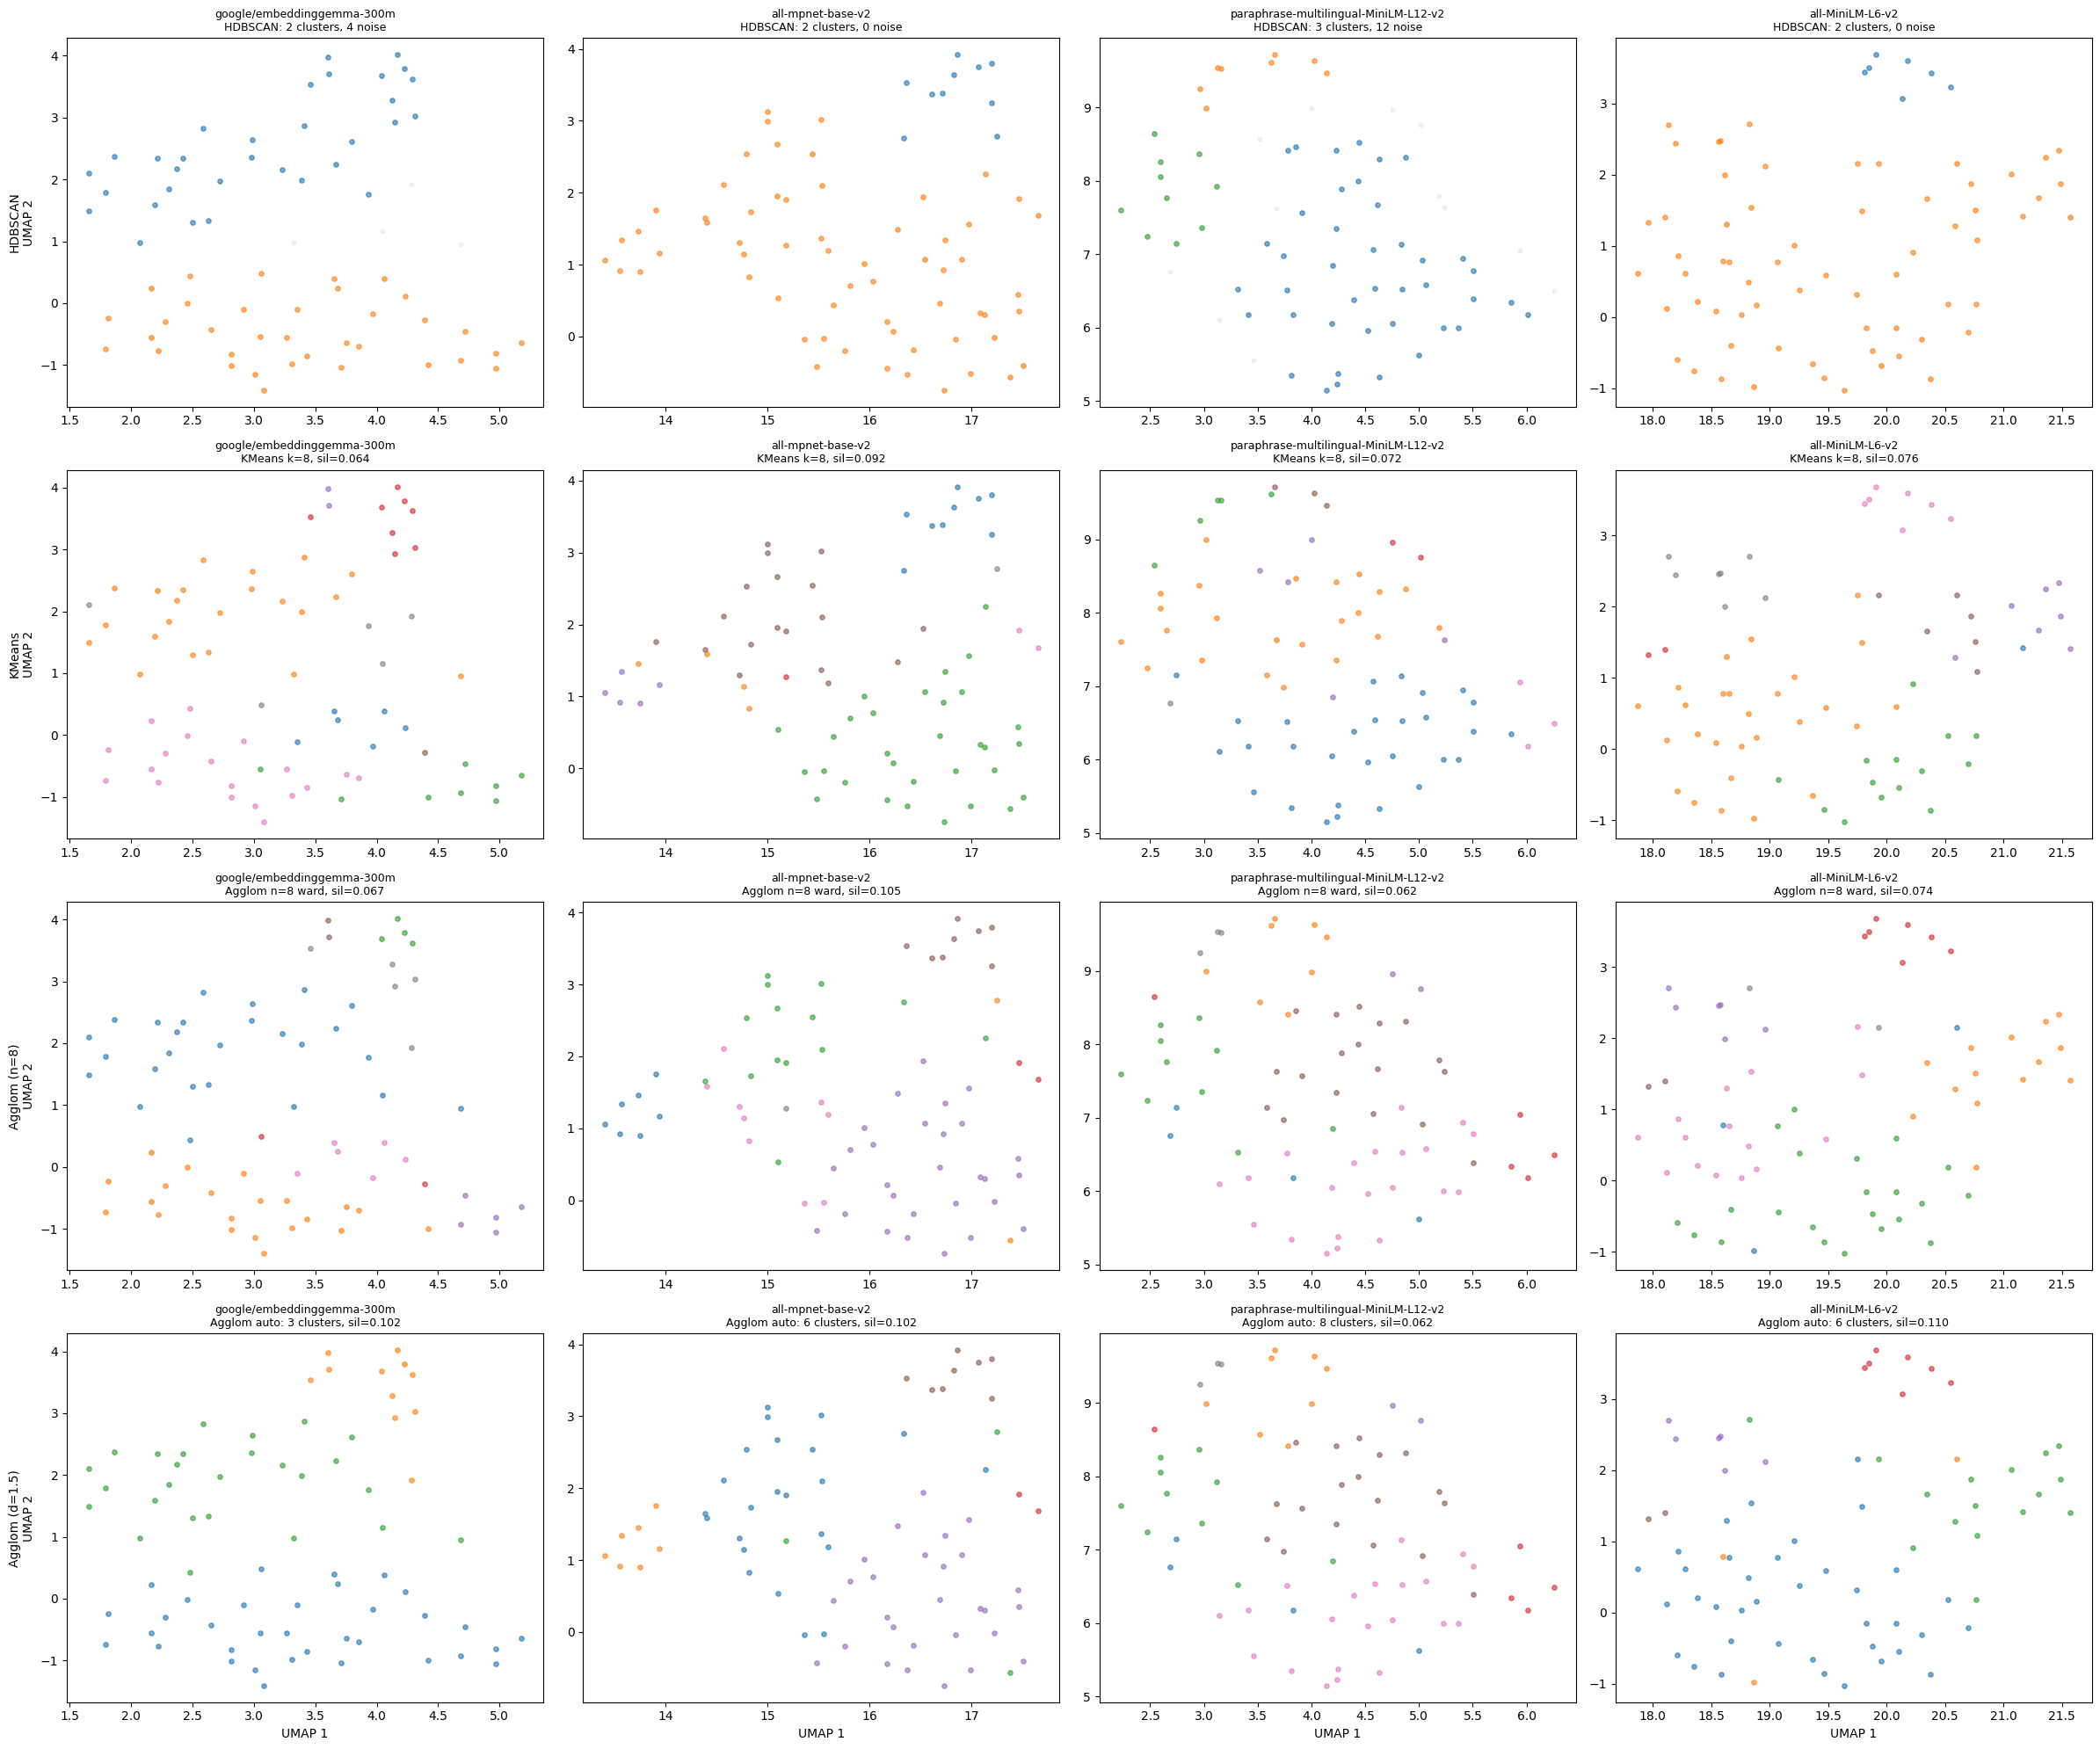

In [99]:
# ── Compare models ─────────────────────────────────────────────────────────
# Re-run embedding + UMAP + all clusterers for each model.
COMPARE_MODELS = [
    "google/embeddinggemma-300m",
    "all-mpnet-base-v2",
    "paraphrase-multilingual-MiniLM-L12-v2",
    "all-MiniLM-L6-v2",
]

ALGO_NAMES = ["HDBSCAN", "KMeans", f"Agglom (n={AGGLOM_N_CLUSTERS})", f"Agglom (d={AGGLOM_DISTANCE_THRESHOLD})"]
texts = df["combined_text"].tolist()
n_models = len(COMPARE_MODELS)
n_algos = len(ALGO_NAMES)

fig, axes = plt.subplots(n_algos, n_models, figsize=(6 * n_models, 5 * n_algos))
if n_models == 1:
    axes = axes[:, np.newaxis]

for col, mname in enumerate(COMPARE_MODELS):
    print(f"Encoding with {mname} (device={DEVICE})...")
    m = SentenceTransformer(mname, device=DEVICE)
    emb = m.encode(texts, show_progress_bar=True)
    emb = normalize(emb)
    proj = UMAP(n_neighbors=UMAP_N_NEIGHBORS, min_dist=UMAP_MIN_DIST, random_state=42).fit_transform(emb)

    # HDBSCAN
    hdb_labels = hdbscan.HDBSCAN(
        min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE, min_samples=HDBSCAN_MIN_SAMPLES
    ).fit_predict(proj)
    hdb_n = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
    hdb_noise = (hdb_labels == -1).sum()

    # KMeans
    km_labels = KMeans(n_clusters=KMEANS_N_CLUSTERS, random_state=42, n_init=10).fit_predict(emb)
    km_sil = silhouette_score(emb, km_labels)

    # Agglomerative (fixed n_clusters)
    if AGGLOM_LINKAGE == "ward":
        ag_labels = AgglomerativeClustering(n_clusters=AGGLOM_N_CLUSTERS, linkage="ward").fit_predict(emb)
    else:
        from sklearn.metrics import pairwise_distances
        dm = pairwise_distances(emb, metric="cosine")
        ag_labels = AgglomerativeClustering(
            n_clusters=AGGLOM_N_CLUSTERS, linkage=AGGLOM_LINKAGE, metric="precomputed"
        ).fit_predict(dm)
    ag_sil = silhouette_score(emb, ag_labels)

    # Agglomerative (auto n_clusters via distance_threshold)
    ag_auto = AgglomerativeClustering(
        n_clusters=None, distance_threshold=AGGLOM_DISTANCE_THRESHOLD, linkage="ward"
    )
    ag_auto_labels = ag_auto.fit_predict(emb)
    ag_auto_n = len(set(ag_auto_labels))
    ag_auto_sil = silhouette_score(emb, ag_auto_labels) if ag_auto_n >= 2 else float("nan")

    all_labels = [hdb_labels, km_labels, ag_labels, ag_auto_labels]
    subtitles = [
        f"HDBSCAN: {hdb_n} clusters, {hdb_noise} noise",
        f"KMeans k={KMEANS_N_CLUSTERS}, sil={km_sil:.3f}",
        f"Agglom n={AGGLOM_N_CLUSTERS} {AGGLOM_LINKAGE}, sil={ag_sil:.3f}",
        f"Agglom auto: {ag_auto_n} clusters, sil={ag_auto_sil:.3f}",
    ]

    for row, (labels, subtitle) in enumerate(zip(all_labels, subtitles)):
        ax = axes[row, col]
        noise_mask = labels == -1
        if noise_mask.any():
            ax.scatter(proj[noise_mask, 0], proj[noise_mask, 1],
                       c="lightgray", alpha=0.3, s=10)
        for cl in sorted(set(labels) - {-1}):
            mask = labels == cl
            ax.scatter(proj[mask, 0], proj[mask, 1], alpha=0.6, s=15, label=f"c{cl}")
        ax.set_title(f"{mname}\n{subtitle}", fontsize=9)
        if col == 0:
            ax.set_ylabel(f"{ALGO_NAMES[row]}\nUMAP 2")
        if row == n_algos - 1:
            ax.set_xlabel("UMAP 1")

plt.tight_layout()
plt.show()

/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered

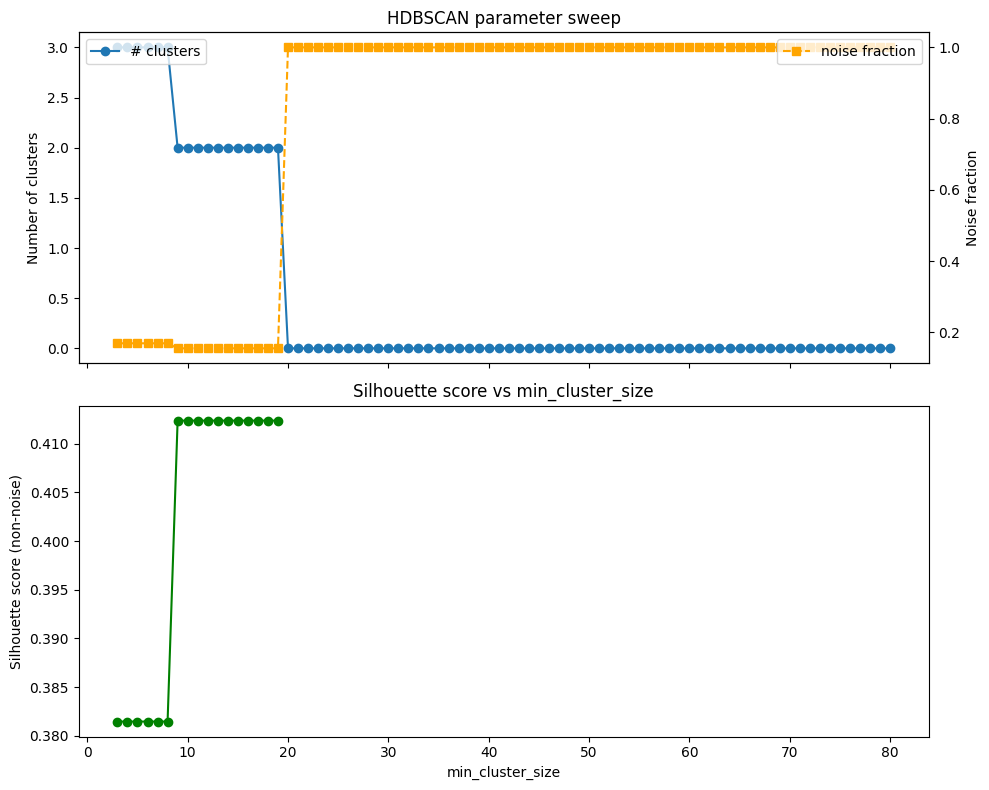

In [100]:
# ── Parameter sweep: HDBSCAN min_cluster_size ──────────────────────────────
sweep_values = list(range(3, 81))
n_clusters_list = []
noise_frac_list = []
sil_list = []

for mcs in sweep_values:
    labels = hdbscan.HDBSCAN(
        min_cluster_size=mcs, min_samples=HDBSCAN_MIN_SAMPLES
    ).fit_predict(umap_2d)
    n_cl = len(set(labels)) - (1 if -1 in labels else 0)
    n_ns = (labels == -1).sum()
    n_clusters_list.append(n_cl)
    noise_frac_list.append(n_ns / len(labels))
    if n_cl >= 2:
        non_noise = labels != -1
        sil_list.append(silhouette_score(umap_2d[non_noise], labels[non_noise]))
    else:
        sil_list.append(np.nan)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(sweep_values, n_clusters_list, "o-", label="# clusters")
ax1b = ax1.twinx()
ax1b.plot(sweep_values, noise_frac_list, "s--", color="orange", label="noise fraction")
ax1.set_ylabel("Number of clusters")
ax1b.set_ylabel("Noise fraction")
ax1.legend(loc="upper left")
ax1b.legend(loc="upper right")
ax1.set_title("HDBSCAN parameter sweep")

ax2.plot(sweep_values, sil_list, "o-", color="green")
ax2.set_xlabel("min_cluster_size")
ax2.set_ylabel("Silhouette score (non-noise)")
ax2.set_title("Silhouette score vs min_cluster_size")

plt.tight_layout()
plt.show()

In [101]:
# ── Parameter sweep: KMeans n_clusters ─────────────────────────────────────
km_sweep = list(range(2, 81))
km_sil_list = []
km_inertia_list = []

for k in km_sweep:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(embeddings)
    km_inertia_list.append(km.inertia_)
    km_sil_list.append(silhouette_score(embeddings, labels))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(km_sweep, km_inertia_list, "o-", color="tab:blue")
ax1.set_ylabel("Inertia (within-cluster SS)")
ax1.set_title("KMeans parameter sweep (elbow plot)")

ax2.plot(km_sweep, km_sil_list, "o-", color="green")
ax2.set_xlabel("n_clusters (k)")
ax2.set_ylabel("Silhouette score")
ax2.set_title("Silhouette score vs k")

plt.tight_layout()
plt.show()

/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mahae/venvs/test/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered

ValueError: Number of labels is 71. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
# ── Parameter sweep: Agglomerative n_clusters + linkage ────────────────────
ag_sweep = list(range(2, 61))
linkages = ["ward", "complete", "average"]
ag_results = {}

for link in linkages:
    sil_list = []
    for n in ag_sweep:
        if link == "ward":
            labels = AgglomerativeClustering(n_clusters=n, linkage="ward").fit_predict(embeddings)
        else:
            from sklearn.metrics import pairwise_distances
            dm = pairwise_distances(embeddings, metric="cosine")
            labels = AgglomerativeClustering(
                n_clusters=n, linkage=link, metric="precomputed"
            ).fit_predict(dm)
        sil_list.append(silhouette_score(embeddings, labels))
    ag_results[link] = sil_list

fig, ax = plt.subplots(figsize=(10, 5))
for link, sils in ag_results.items():
    ax.plot(ag_sweep, sils, "o-", label=link)
ax.set_xlabel("n_clusters")
ax.set_ylabel("Silhouette score")
ax.set_title("Agglomerative clustering parameter sweep")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ── Parameter sweep: Agglomerative distance_threshold ──────────────────────
dt_sweep = np.arange(0.1, 1.5, 0.05)
dt_results = {}

for link in ["ward", "complete", "average"]:
    n_clusters_list = []
    sil_list = []
    for dt in dt_sweep:
        if link == "ward":
            labels = AgglomerativeClustering(
                n_clusters=None, distance_threshold=dt, linkage="ward"
            ).fit_predict(embeddings)
        else:
            from sklearn.metrics import pairwise_distances
            dm = pairwise_distances(embeddings, metric="cosine")
            labels = AgglomerativeClustering(
                n_clusters=None, distance_threshold=dt, linkage=link, metric="precomputed"
            ).fit_predict(dm)
        n_cl = len(set(labels))
        n_clusters_list.append(n_cl)
        sil_list.append(silhouette_score(embeddings, labels) if n_cl >= 2 else np.nan)
    dt_results[link] = {"n_clusters": n_clusters_list, "silhouette": sil_list}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for link, res in dt_results.items():
    ax1.plot(dt_sweep, res["n_clusters"], "o-", label=link)
    ax2.plot(dt_sweep, res["silhouette"], "o-", label=link)

ax1.set_ylabel("Number of clusters")
ax1.set_title("Agglomerative distance_threshold sweep")
ax1.legend()

ax2.set_xlabel("distance_threshold")
ax2.set_ylabel("Silhouette score")
ax2.set_title("Silhouette score vs distance_threshold")
ax2.legend()

plt.tight_layout()
plt.show()